### Подход 1: градиентный бустинг "в лоб"

1. Считайте таблицу с признаками из файла features.csv с помощью кода, приведенного выше. Удалите признаки, связанные с итогами матча (они помечены в описании данных как отсутствующие в тестовой выборке).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
features = pd.read_csv('data/features.csv', index_col='match_id')

features.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,4,2,2,-52.0,2874,1,1796,0,51,0
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,4,3,1,-5.0,2463,1,1974,0,63,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,4,3,1,13.0,2130,0,0,1830,0,63
3,1430263531,1,29,4,1779,1056,14,0,0,5,...,4,2,0,27.0,1459,0,1920,2047,50,63
4,1430282290,7,13,4,1431,1090,8,1,0,8,...,3,3,0,-16.0,2449,0,4,1974,3,63


In [2]:
# y содержит итоги матчей
match_results = features.iloc[:,-6:]

In [3]:
# признаки без итогов матча
Xdirty = features.drop(columns=match_results.columns)

2. Проверьте выборку на наличие пропусков с помощью функции count(), которая для каждого столбца показывает число заполненных значений. Много ли пропусков в данных? Запишите названия признаков, имеющих пропуски, и попробуйте для любых двух из них дать обоснование, почему их значения могут быть пропущены.

In [4]:
# столбцы с пропусками
Xdirty.columns[Xdirty.isna().any()].tolist()

['first_blood_time',
 'first_blood_team',
 'first_blood_player1',
 'first_blood_player2',
 'radiant_bottle_time',
 'radiant_courier_time',
 'radiant_flying_courier_time',
 'radiant_first_ward_time',
 'dire_bottle_time',
 'dire_courier_time',
 'dire_flying_courier_time',
 'dire_first_ward_time']

In [5]:
# доля пропусков в признаках
Nan_count = len(Xdirty)-Xdirty.count()
Nan_count[Nan_count>0].sort_values(ascending=False)/len(Xdirty)

first_blood_player2            0.452402
radiant_flying_courier_time    0.282619
dire_flying_courier_time       0.268415
first_blood_player1            0.201100
first_blood_team               0.201100
first_blood_time               0.201100
dire_bottle_time               0.166029
radiant_bottle_time            0.161380
radiant_first_ward_time        0.018883
dire_first_ward_time           0.018780
radiant_courier_time           0.007117
dire_courier_time              0.006953
dtype: float64

In [ ]:
# Объясение пропусков в данных
#'first_blood_player2' - в 45% случаев 2 игрок не делает первую кровь в первые 5 минут
#'radiant_flying_courier_time' - в 28% случаев "flying_courier" в первые 5 минут игры никто не получит

3. Замените пропуски на нули с помощью функции fillna(). На самом деле этот способ является предпочтительным для логистической регрессии, поскольку он позволит пропущенному значению не вносить никакого вклада в предсказание. Для деревьев часто лучшим вариантом оказывается замена пропуска на очень большое или очень маленькое значение — в этом случае при построении разбиения вершины можно будет отправить объекты с пропусками в отдельную ветвь дерева. Также есть и другие подходы — например, замена пропуска на среднее значение признака. Мы не требуем этого в задании, но при желании попробуйте разные подходы к обработке пропусков и сравните их между собой.

In [6]:
# Замена пропусков нулями
X = Xdirty.fillna(0)

4. Какой столбец содержит целевую переменную? Запишите его название.

In [7]:
# 'radiant_win' - целевая переменная
y = match_results['radiant_win']

5. Забудем, что в выборке есть категориальные признаки, и попробуем обучить градиентный бустинг над деревьями на имеющейся матрице "объекты-признаки". Зафиксируйте генератор разбиений для кросс-валидации по 5 блокам (KFold), не забудьте перемешать при этом выборку (shuffle=True), поскольку данные в таблице отсортированы по времени, и без перемешивания можно столкнуться с нежелательными эффектами при оценивании качества. Оцените качество градиентного бустинга (GradientBoostingClassifier) с помощью данной кросс-валидации, попробуйте при этом разное количество деревьев (как минимум протестируйте следующие значения для количества деревьев: 10, 20, 30). Долго ли настраивались классификаторы? Достигнут ли оптимум на испытанных значениях параметра n_estimators, или же качество, скорее всего, продолжит расти при дальнейшем его увеличении?

In [8]:
import time
import datetime
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier

kf = KFold(n_splits=5, shuffle=True, random_state=241)

n_classif = [10,20,30,50,70]
i=0
score=np.zeros(5)

for n in n_classif:
    start_time = datetime.datetime.now()
    clf = GradientBoostingClassifier(n_estimators=n)
    score[i] = cross_val_score(clf, X, y, scoring='roc_auc', cv=kf, n_jobs=-1, verbose=0).mean()
    print('For n_estimators: {}\nAUC-ROC score: {:.2f}\nTime elapsed: {}\n'.format(n,score[i],datetime.datetime.now()-start_time))
    i+=1

For n_estimators: 10
AUC-ROC score: 0.66
Time elapsed: 0:00:39.089717

For n_estimators: 20
AUC-ROC score: 0.68
Time elapsed: 0:01:04.187611

For n_estimators: 30
AUC-ROC score: 0.69
Time elapsed: 0:01:25.738526

For n_estimators: 50
AUC-ROC score: 0.70
Time elapsed: 0:02:22.806530

For n_estimators: 70
AUC-ROC score: 0.70
Time elapsed: 0:03:14.419778



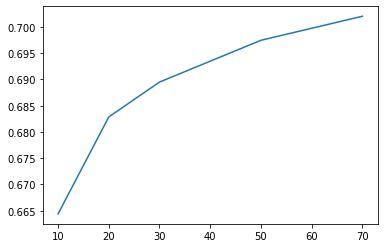

In [51]:
# График зависимости качества
fig=plt.subplots()
plt.plot(n_classif,pd.Series(score))
plt.show()

In [61]:
# Можно констатировать, что оптимум достигнут при 30 деревьях
# Если сравнивать классификаторы с 50 и со 100 деревьями, то прирост в качестве увеличился на 0.1 единицу, 
# при этом время настройки возросло в 2 раза c 2.5 минут до 5

### Отчет:

1. Какие признаки имеют пропуски среди своих значений? Что могут означать пропуски в этих признаках (ответьте на этот вопрос для двух любых признаков)?
-Признаки с пропусками:
'first_blood_time', 'first_blood_team', 'first_blood_player1', 'first_blood_player2','radiant_bottle_time', 'radiant_courier_time', 'radiant_flying_courier_time', 'radiant_first_ward_time', 'dire_bottle_time', 'dire_courier_time', 'dire_flying_courier_time', 'dire_first_ward_time'
-Что могут означать пропуски:
#'first_blood_player2' - в 45% случаев 2 игрок не делает первую кровь в первые 5 минут
#'radiant_flying_courier_time' - в 28% случаев "flying_courier" в первые 5 минут игры никто не получит

2. Как называется столбец, содержащий целевую переменную?
'radiant_win'

3. Как долго проводилась кросс-валидация для градиентного бустинга с 30 деревьями? Инструкцию по измерению времени можно найти ниже по тексту. Какое качество при этом получилось? Напомним, что в данном задании мы используем метрику качества AUC-ROC.
-Время операции: 0:01:31.978534
-Качество: 0.69

4. Имеет ли смысл использовать больше 30 деревьев в градиентном бустинге? Что бы вы предложили делать, чтобы ускорить его обучение при увеличении количества деревьев?
-Нет смысла использовать больше 30 деревьев
-Можно предложить отобрать признаки

## Подход 2: логистическая регрессия

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [11]:
scaler = StandardScaler()
scaler.fit(X)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [12]:
X_scaled = scaler.transform(X)

1. Оцените качество логистической регрессии (sklearn.linear_model.LogisticRegression с L2-регуляризацией) с помощью кросс-валидации по той же схеме, которая использовалась для градиентного бустинга. Подберите при этом лучший параметр регуляризации (C). Какое наилучшее качество у вас получилось? Как оно соотносится с качеством градиентного бустинга? Чем вы можете объяснить эту разницу? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?

In [13]:
score_log_reg=np.zeros(6)
i=0
coef=[0.00001,0.0001,0.001,0.01,0.1,1]
for C in coef:
    start_time = datetime.datetime.now()
    model = LogisticRegression(penalty='l2', C=C, n_jobs=-1)
    score_log_reg[i] = cross_val_score(model, X_scaled, y, scoring='roc_auc', cv=kf, n_jobs=-1, verbose=0).mean()
    print('For regularization coefficient C: {}\nAUC-ROC score: {:.4f}\nTime elapsed: {}\n'.format(C,score_log_reg[i],datetime.datetime.now()-start_time))
    i+=1

For regularization coefficient C: 1e-05
AUC-ROC score: 0.6951
Time elapsed: 0:00:05.482714

For regularization coefficient C: 0.0001
AUC-ROC score: 0.7113
Time elapsed: 0:00:05.897483

For regularization coefficient C: 0.001
AUC-ROC score: 0.7162
Time elapsed: 0:00:10.198682

For regularization coefficient C: 0.01
AUC-ROC score: 0.7163
Time elapsed: 0:00:13.177660

For regularization coefficient C: 0.1
AUC-ROC score: 0.7163
Time elapsed: 0:00:14.579994

For regularization coefficient C: 1
AUC-ROC score: 0.7163
Time elapsed: 0:00:15.401896



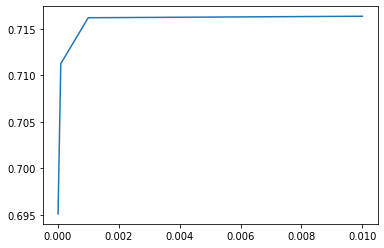

In [14]:
fig=plt.subplots()
plt.plot(coef[0:4],score_log_reg[0:4])
plt.show()

In [143]:
# Наилучший параметр регуляризации 0.01 дает результат под AUC-ROC 0.7163 за время 13 секунд
# Качество градиентного бустинга оказалось незначительно ниже 0.69 против 0.72 
# Скорость работы логистической регрессии оказалась в 7 раз быстрее (1мин31сек против 13 секунд)
# То что лучше работает логистическая регрессия - следствие линейной зависимости признаков и целевой переменной

2. Среди признаков в выборке есть категориальные, которые мы использовали как числовые, что вряд ли является хорошей идеей. Категориальных признаков в этой задаче одиннадцать: lobby_type и r1_hero, r2_hero, ..., r5_hero, d1_hero, d2_hero, ..., d5_hero. Уберите их из выборки, и проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. Изменилось ли качество? Чем вы можете это объяснить?

In [15]:
categorial=['lobby_type']
team=('r','d')
for l in team:
    for i in range(1,6):
        categorial.append('{}{}_hero'.format(l,i))

In [16]:
X_no_cat = X.drop(columns=categorial)
scaler.fit(X_no_cat)
X_scaled2 = scaler.transform(X_no_cat)

In [17]:
score_log2=np.zeros(6)
i=0
coef=[0.00001,0.0001,0.001,0.01,0.1,1]
for C in coef:
    start_time = datetime.datetime.now()
    model = LogisticRegression(penalty='l2', C=C, n_jobs=-1)
    score_log2[i] = cross_val_score(model, X_scaled2, y, scoring='roc_auc', cv=kf, n_jobs=-1, verbose=0).mean()
    print('For regularization coefficient C: {}\nAUC-ROC score: {:.4f}\nTime elapsed: {}\n'.format(C,score_log2[i],datetime.datetime.now()-start_time))
    i+=1

For regularization coefficient C: 1e-05
AUC-ROC score: 0.6951
Time elapsed: 0:00:03.631366

For regularization coefficient C: 0.0001
AUC-ROC score: 0.7112
Time elapsed: 0:00:05.460498

For regularization coefficient C: 0.001
AUC-ROC score: 0.7162
Time elapsed: 0:00:09.414903

For regularization coefficient C: 0.01
AUC-ROC score: 0.7164
Time elapsed: 0:00:12.172401

For regularization coefficient C: 0.1
AUC-ROC score: 0.7164
Time elapsed: 0:00:12.758961

For regularization coefficient C: 1
AUC-ROC score: 0.7164
Time elapsed: 0:00:12.689341



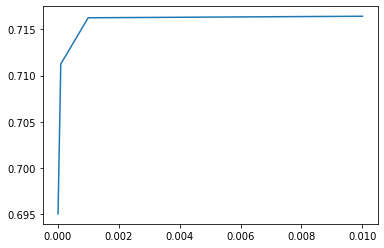

In [18]:
plt.plot(coef[0:4],score_log2[0:4])
plt.show()

In [202]:
# Качество классификатора не изменилось после удаления категориальных признаков. 
# Значит признак не оказал влияния на классификацию в предыдущем случае 

3. На предыдущем шаге мы исключили из выборки признаки rM_hero и dM_hero, которые показывают, какие именно герои играли за каждую команду. Это важные признаки — герои имеют разные характеристики, и некоторые из них выигрывают чаще, чем другие. Выясните из данных, сколько различных идентификаторов героев существует в данной игре (вам может пригодиться фукнция unique или value_counts).

In [19]:
X_hero = X[categorial].iloc[:,1:]
unique_hero = len(np.unique(X_hero))
ids = X_hero.iloc[:,1].max()
print('Количество идентификаторов в игре: {}\nКоличество уникальных id: {}'.format(ids,unique_hero) )

Количество идентификаторов в игре: 112
Количество уникальных id: 108


4. Воспользуемся подходом "мешок слов" для кодирования информации о героях. Пусть всего в игре имеет N различных героев. Сформируем N признаков, при этом i-й будет равен нулю, если i-й герой не участвовал в матче; единице, если i-й герой играл за команду Radiant; минус единице, если i-й герой играл за команду Dire. Ниже вы можете найти код, который выполняет данной преобразование. Добавьте полученные признаки к числовым, которые вы использовали во втором пункте данного этапа.

In [21]:
# N — количество различных героев в выборке
X_pick = np.zeros((X_hero.shape[0], ids))

for i, match_id in enumerate(X_hero.index):
    for p in range(5):
        X_pick[i, X_hero.loc[match_id, 'r%d_hero' % (p+1)]-1] = 1
        X_pick[i, X_hero.loc[match_id, 'd%d_hero' % (p+1)]-1] = -1

In [22]:
X_pick = pd.DataFrame(X_pick, index=X_hero.index, columns=['{}_hero'.format(i) for i in range (ids)])

In [23]:
X_ = pd.concat([X_no_cat, X_pick],axis=1)

5. Проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. Какое получилось качество? Улучшилось ли оно? Чем вы можете это объяснить?

In [24]:
scaler.fit(X_)
X_scaled3 = scaler.transform(X_)

In [25]:
score_log3=np.zeros(9)
i=0
coef=[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]
for C in coef:
    start_time = datetime.datetime.now()
    model = LogisticRegression(penalty='l2', C=C, n_jobs=-1)
    score_log3[i] = cross_val_score(model, X_scaled3, y, scoring='roc_auc', cv=kf, n_jobs=-1, verbose=0).mean()
    print('For regularization coefficient C: {}\nAUC-ROC score: {:.4f}\nTime elapsed: {}\n'.format(C,score_log3[i],datetime.datetime.now()-start_time))
    i+=1

For regularization coefficient C: 1e-05
AUC-ROC score: 0.7148
Time elapsed: 0:00:21.625099

For regularization coefficient C: 0.0001
AUC-ROC score: 0.7428
Time elapsed: 0:00:10.314624

For regularization coefficient C: 0.001
AUC-ROC score: 0.7517
Time elapsed: 0:00:18.595496

For regularization coefficient C: 0.01
AUC-ROC score: 0.7520
Time elapsed: 0:00:24.269255

For regularization coefficient C: 0.1
AUC-ROC score: 0.7519
Time elapsed: 0:00:26.611028

For regularization coefficient C: 1
AUC-ROC score: 0.7519
Time elapsed: 0:00:29.663913

For regularization coefficient C: 10
AUC-ROC score: 0.7519
Time elapsed: 0:00:35.316897

For regularization coefficient C: 100
AUC-ROC score: 0.7519
Time elapsed: 0:00:30.688618

For regularization coefficient C: 1000
AUC-ROC score: 0.7519
Time elapsed: 0:00:29.445142



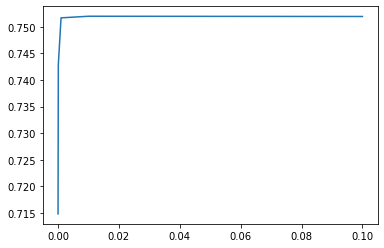

In [26]:
plt.plot(coef[0:5],score_log3[0:5])
plt.show()

In [335]:
# Качество классификатора возрасло с 0.7163 до 0.7520
# Лучшие результаты модель показывает при регуляризации С=0.01 качество 0.7520
# Новые признаки позволяют выявить новую зависимость с целевой переменной

6. Постройте предсказания вероятностей победы команды Radiant для тестовой выборки с помощью лучшей из изученных моделей (лучшей с точки зрения AUC-ROC на кросс-валидации). Убедитесь, что предсказанные вероятности адекватные — находятся на отрезке [0, 1], не совпадают между собой (т.е. что модель не получилась константной).

In [38]:
X_test_dirty = pd.read_csv('features_test.csv', index_col='match_id')
X_test_dirty.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time
match_id,,,,,,,,,,,,,,,,,,,,,
6,1430287923,0,93,4,1103,1089,8,0,1,9,...,0,12.0,247.0,-86.0,272.0,3,4,2,0,118.0
7,1430293357,1,20,2,556,570,1,0,0,9,...,2,-29.0,168.0,-54.0,NaN,3,2,2,1,16.0
10,1430301774,1,112,2,751,808,1,0,0,13,...,1,-22.0,46.0,-87.0,186.0,1,3,3,0,-34.0
13,1430323933,1,27,3,708,903,1,1,1,11,...,2,-49.0,30.0,-89.0,210.0,3,4,2,1,-26.0
16,1430331112,1,39,4,1259,661,4,0,0,9,...,0,36.0,180.0,-86.0,180.0,1,3,2,1,-33.0


In [39]:
X_hero = X_test_dirty[categorial].iloc[:,1:]

In [40]:
X_test = X_test_dirty.drop(columns=categorial).fillna(0)

((17177, 91), (17177, 10))

In [42]:
X_pick = np.zeros((X_hero.shape[0], ids))

for i, match_id in enumerate(X_hero.index):
    for p in range(5):
        X_pick[i, X_hero.loc[match_id, 'r%d_hero' % (p+1)]-1] = 1
        X_pick[i, X_hero.loc[match_id, 'd%d_hero' % (p+1)]-1] = -1
X_pick =pd.DataFrame(X_pick, index=X_hero.index, columns=['{}_hero'.format(i) for i in range(ids)])

(17177, 112)

In [43]:
X_test = pd.concat([X_test,X_pick],axis=1)

(17177, 203)

In [44]:
scaler.fit(X_test)
X_scale = scaler.transform(X_test)

In [48]:
score_summary=np.zeros(5)

model = LogisticRegression(penalty='l2', C=0.01)
model.fit(X_scaled3,y)
y_pred = pd.Series(model.predict_proba(X_scale)[:,1])
print(y_pred)

C:\Users\Alexey.000\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0        0.822689
1        0.756018
2        0.188658
3        0.856746
4        0.241456
           ...   
17172    0.718821
17173    0.631443
17174    0.233771
17175    0.631057
17176    0.429138
Length: 17177, dtype: float64


In [49]:
y_pred.describe()

count    17177.000000
mean         0.518372
std          0.220499
min          0.008706
25%          0.347831
50%          0.523721
75%          0.692671
max          0.996329
dtype: float64

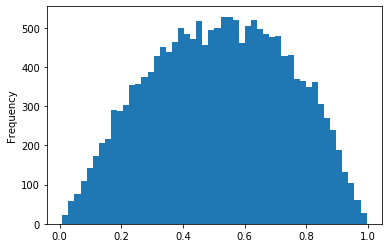

In [50]:
y_pred.plot.hist(bins=50)

### Отчет

1. Какое качество получилось у логистической регрессии над всеми исходными признаками? Как оно соотносится с качеством градиентного бустинга? Чем вы можете объяснить эту разницу? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?
-Наилучший параметр регуляризации 0.01 дает качество 0.7163 за время 13 секунд
-Качество градиентного бустинга оказалось незначительно ниже 0.69 против 0.72 
-То что лучше работает логистическая регрессия - следствие линейной зависимости признаков и целевой переменной
-Скорость работы логистической регрессии оказалась в 7 раз быстрее (1мин31сек против 13 секунд)

2. Как влияет на качество логистической регрессии удаление категориальных признаков (укажите новое значение метрики качества)? Чем вы можете объяснить это изменение?
-Качество классификатора не изменилось после удаления категориальных признаков(значение 0.7164). 
-Значит признак не оказал влияния на классификацию в предыдущем случае 

3. Сколько различных идентификаторов героев существует в данной игре?
-112

4. Какое получилось качество при добавлении "мешка слов" по героям? Улучшилось ли оно по сравнению с предыдущим вариантом? Чем вы можете это объяснить?
-Качество классификатора возросло с 0.7163 до 0.7520
-Лучшие результаты модель показывает при регуляризации С=0.01 качество 0.7520
-Новые признаки позволяют выявить новую зависимость с целевой переменной

5. Какое минимальное и максимальное значение прогноза на тестовой выборке получилось у лучшего из алгоритмов?
-y_pred_min = 0.004416, y_pred_max = 0.997443